# Top level

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json, os, shutil, requests, textwrap

import pickle
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

if 'google.colab' in str(get_ipython()):
  currentDir = os.path.join("/", "content", "drive", "My Drive", "Colab Notebooks", "YGO")
else:
  currentDir = os.getcwd()

print(currentDir)
os.chdir(os.path.join(currentDir, "scripts"))
from image_funcs import ImageDl, progress_update, make_splits, move_card_images, update_filenames, crop_image

os.chdir(os.path.dirname(os.getcwd()))

In [ ]:
# Dictionary with card data
data = json.load(open(os.path.join(currentDir, "data", "cardinfo.php"), "r")) 

# Data frame with all cards
if os.path.exists(os.path.join(currentDir, "data", "data_frame.pkl")):
  df = pd.read_pickle(os.path.join(currentDir, "data", "data_frame.pkl"))

# Data frame with only cards in archetypes with >= 20 cards
if os.path.exists(os.path.join(currentDir, "data", "df_large.pkl")):
  df_large = pd.read_pickle(os.path.join(currentDir, "data", "df_large.pkl"))

# Exploratory/descriptive analysis

## General

In [ ]:
# Example entry for one card
df.iloc[0]

id                                                      34541863
name                                    "A" Cell Breeding Device
type                                                  Spell Card
desc           During each of your Standby Phases, put 1 A-Co...
race                                                  Continuous
archetype                                                  Alien
card_sets      [{'set_name': 'Force of the Breaker', 'set_cod...
card_images    [{'id': 34541863, 'image_url': 'https://storag...
card_prices    [{'cardmarket_price': '0.13', 'tcgplayer_price...
short_type                                                 Spell
Name: 0, dtype: object

In [ ]:
pends = ["Pendulum" in df.type[i] for i in range(len(df.type))]
print(len(df), "total cards")
print(df[[not i for i in pends]].type.count(), "non-pendulum cards.")
print(df[pends].type.count(), "pendulum cards.")
print(df[pends].groupby("archetype").archetype.count())

11149 total cards
10872 non-pendulum cards.
277 pendulum cards.
archetype
Abyss Actor          12
Aether                1
Amorphage             8
Archfiend             1
Bujin                 1
Chaos                 1
Clear Wing            2
Crystal Beast         2
D/D                  24
Deskbot               4
Dinomist              8
Doremichord           8
Doriado               1
Dracoslayer           2
Dracoverlord          2
Edge Imp              1
Empowered Warrior     2
Endymion              4
Fluffal               1
Frightfur             1
Igknight              8
Lunalight             2
Magician             11
Majespecter           6
Metalfoes             7
Metaphys              1
NA                   50
Nekroz                2
Ninja                 2
Odd-Eyes             27
Performage            2
Performapal          38
Predaplant            1
Qli                   8
Ritual Beast          2
Roid                  2
Shaddoll              2
Speedroid             2
Stellarknight 

## Card type

In [ ]:
b = df.groupby("short_type").short_type.count().tolist()
pct = [round(100*i/sum(b), 3) for i in b]

b = pd.DataFrame(b,
                 columns=["Count"],
                 index=["Monster", "Spell", "Trap"])
b["%"] = pct

display(b)

,Count,%
Monster,7434,66.679
Spell,2081,18.665
Trap,1634,14.656


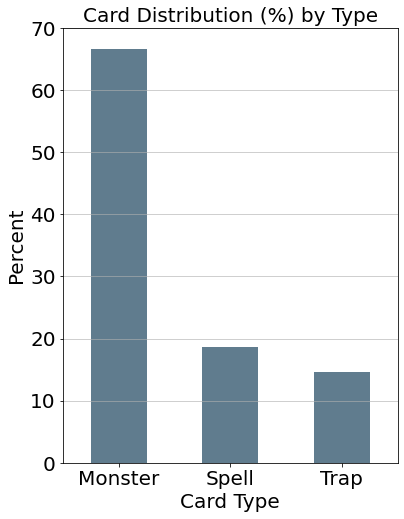

In [ ]:
fix, ax = plt.subplots(figsize=(6, 8))
b["%"].plot.bar(color='#607c8e')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylabel("Percent", fontsize=20)
plt.xlabel("Card Type", fontsize=20)
plt.title("Card Distribution (%) by Type", fontsize=20)
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=0)
plt.savefig(os.path.join(currentDir, "report", "figures", "card_type.pdf"), bbox_inches='tight')
plt.show()

In [ ]:
c = df.groupby("general_type").general_type.count().tolist()
pct = [round(100*i/sum(c), 3) for i in c]
c = pd.DataFrame(c, columns=["Count"],
                 index=df.groupby("general_type").general_type.count().index)
c["%"] = pct
c = c.sort_values(by="%")

display(c)

,Count,%
general_type,,
Toon Monster,17,0.152
Spirit Monster,30,0.269
Union Monster,36,0.323
Gemini Monster,43,0.386
Skill Card,70,0.628
Ritual Monster,102,0.915
Token,107,0.960
Flip Monster,170,1.525
Pendulum Monster,267,2.395


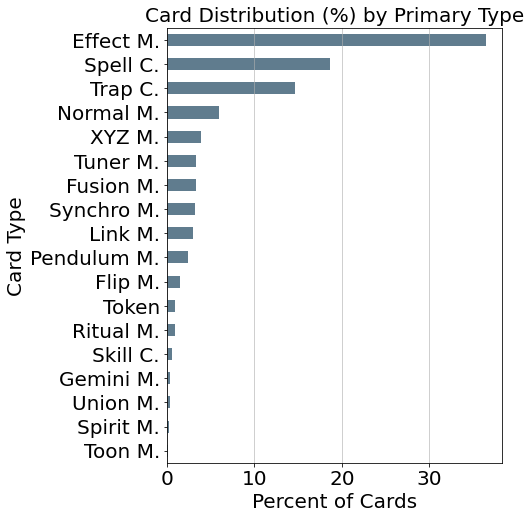

In [ ]:
c.index = [str(i).replace("Monster", "M.") for i in c.index]
c.index = [str(i).replace("Card", "C.") for i in c.index]

fix, ax = plt.subplots(figsize=(6, 8))
c["%"].plot.barh(color='#607c8e')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel("Percent of Cards", fontsize=20)
plt.ylabel("Card Type", fontsize=20)
plt.title("Card Distribution (%) by Primary Type", fontsize=20)
plt.grid(axis='x', alpha=0.75)
plt.xticks(rotation=0)
plt.savefig(os.path.join(currentDir, "report", "figures", "card_type_general.pdf"), bbox_inches='tight')
plt.show()

## Archetype

### "Large" archetypes ($n\geq 20$)

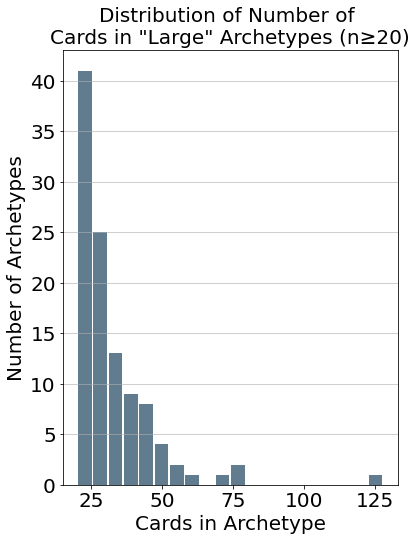

3451 cards in the 107 'large' archetypes. (Avg. cards/archetype: 32.25)
Most common archetype is 'Elemental HERO' with 128 cards (3.71% of cards from 'large' archetypes).


In [ ]:
fix, ax = plt.subplots(figsize=(6, 8))
df_large.groupby("archetype").archetype.count().plot.hist(bins=20,
                                                              rwidth=0.9,
                                                              color='#607c8e')
ax.tick_params(axis='both', which='major', labelsize=20)
plt.title('Distribution of Number of \nCards in "Large" Archetypes (n≥20)', fontsize=20)
plt.xlabel('Cards in Archetype', fontsize=20)
plt.ylabel('Number of Archetypes', fontsize=20)
plt.grid(axis='y', alpha=0.75)
plt.savefig(os.path.join(currentDir, "report", "figures", "large_arch.pdf"), bbox_inches='tight')
plt.show()

# Number of cards/archetypes remaining
print(len(df_large['archetype']), "cards in the",
      len(df_large.archetype.unique()), "'large' archetypes. " +
      "(Avg. cards/archetype: " +
      str(round(len(df_large['archetype'])/
        len(df_large.archetype.unique()), 2)) + ")")

print("Most common archetype is \'", a.idxmax(), "\' with ", a.max(), " cards (", 
      round(100*a.max()/len(df_large['archetype']), 2),
      "% of cards from 'large' archetypes).", sep="")

### Largest and smallest archetypes (with $n\geq 20$)

In [ ]:
top_10 = a[a>=20].sort_values(ascending=False)[0:10].index.tolist()
top_5 = a[a>=20].sort_values(ascending=False)[0:5].index.tolist()
bottom_10 = a[a>=20].sort_values(ascending=False)[-10:].index.tolist()

top_out, btm_out = [], []
for i in range(len(top_10)):
  top_out.append([top_10[i],
                  a.loc[top_10[i]],
                  str(round(100*a.loc[top_10[i]]/
                            sum(a.loc[top_10]), 3))+"%",
                  str(round(100*a.loc[top_10[i]]/
                            sum(a[a>=20]), 3))+"%",
                  str(round(100*a.loc[top_10[i]]/
                            len(data["data"]), 3))+"%"])
  btm_out.append([bottom_10[i],
                  a.loc[bottom_10[i]],
                  str(round(100*a.loc[bottom_10[i]]/
                            sum(a.loc[bottom_10]), 3))+"%",
                  str(round(100*a.loc[bottom_10[i]]/
                            sum(a[a>=20]), 3))+"%",
                  str(round(100*a.loc[bottom_10[i]]/
                            len(data["data"]), 3))+"%"])

top_out = pd.DataFrame(top_out, columns=["Name", "No. Cards", "% top 10", "% 'large'", "% total"])
top_out.index += 1

btm_out = pd.DataFrame(btm_out, columns=["Name", "No. Cards", "% bottom 10", "% 'large'", "% total"])
btm_out.index += 1

# Top and bottom 10 archetypes
print("")
print("Top 10 archetypes:")
display(top_out)
print("")
print("Bottom 10 'large' archetypes:")
display(btm_out)
print("")


Top 10 archetypes:


,Name,No. Cards,% top 10,% 'large',% total
1,Elemental HERO,128,18.963%,3.709%,1.148%
2,Performapal,79,11.704%,2.289%,0.709%
3,Archfiend,78,11.556%,2.26%,0.7%
4,Blackwing,73,10.815%,2.115%,0.655%
5,D/D,61,9.037%,1.768%,0.547%
6,Gladiator Beast,56,8.296%,1.623%,0.502%
7,Roid,56,8.296%,1.623%,0.502%
8,Dark Magician,48,7.111%,1.391%,0.431%
9,Six Samurai,48,7.111%,1.391%,0.431%
10,Noble Knight,48,7.111%,1.391%,0.431%



Bottom 10 'large' archetypes:


,Name,No. Cards,% bottom 10,% 'large',% total
1,Infernoid,21,10.396%,0.609%,0.188%
2,Yosenju,21,10.396%,0.609%,0.188%
3,Cloudian,20,9.901%,0.58%,0.179%
4,Nordic,20,9.901%,0.58%,0.179%
5,Nekroz,20,9.901%,0.58%,0.179%
6,Sylvan,20,9.901%,0.58%,0.179%
7,Assault Mode,20,9.901%,0.58%,0.179%
8,Hieratic,20,9.901%,0.58%,0.179%
9,Melodious,20,9.901%,0.58%,0.179%
10,Kuriboh,20,9.901%,0.58%,0.179%
